In [1]:
# Import necessary libraries

import os
import numpy as np
import pandas as pd
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import cv2 as cv
from time import time
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import cv2

from sklearn.metrics import confusion_matrix

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

170498071/170498071 [==============================] - 5s 0us/step
X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


In [3]:
# converting data from RGB scale to grayscale for training images

x_train_gry = np.zeros(X_train.shape[:-1])
for i in range(X_train.shape[0]):
   x_train_gry[i] = cv2.cvtColor(X_train[i], cv2.COLOR_BGR2GRAY)

In [4]:
# converting data from RGB scale to grayscale for test images

x_test_gry = np.zeros(X_test.shape[:-1])
for i in range(X_test.shape[0]):
   x_test_gry[i] = cv2.cvtColor(X_test[i], cv2.COLOR_BGR2GRAY)

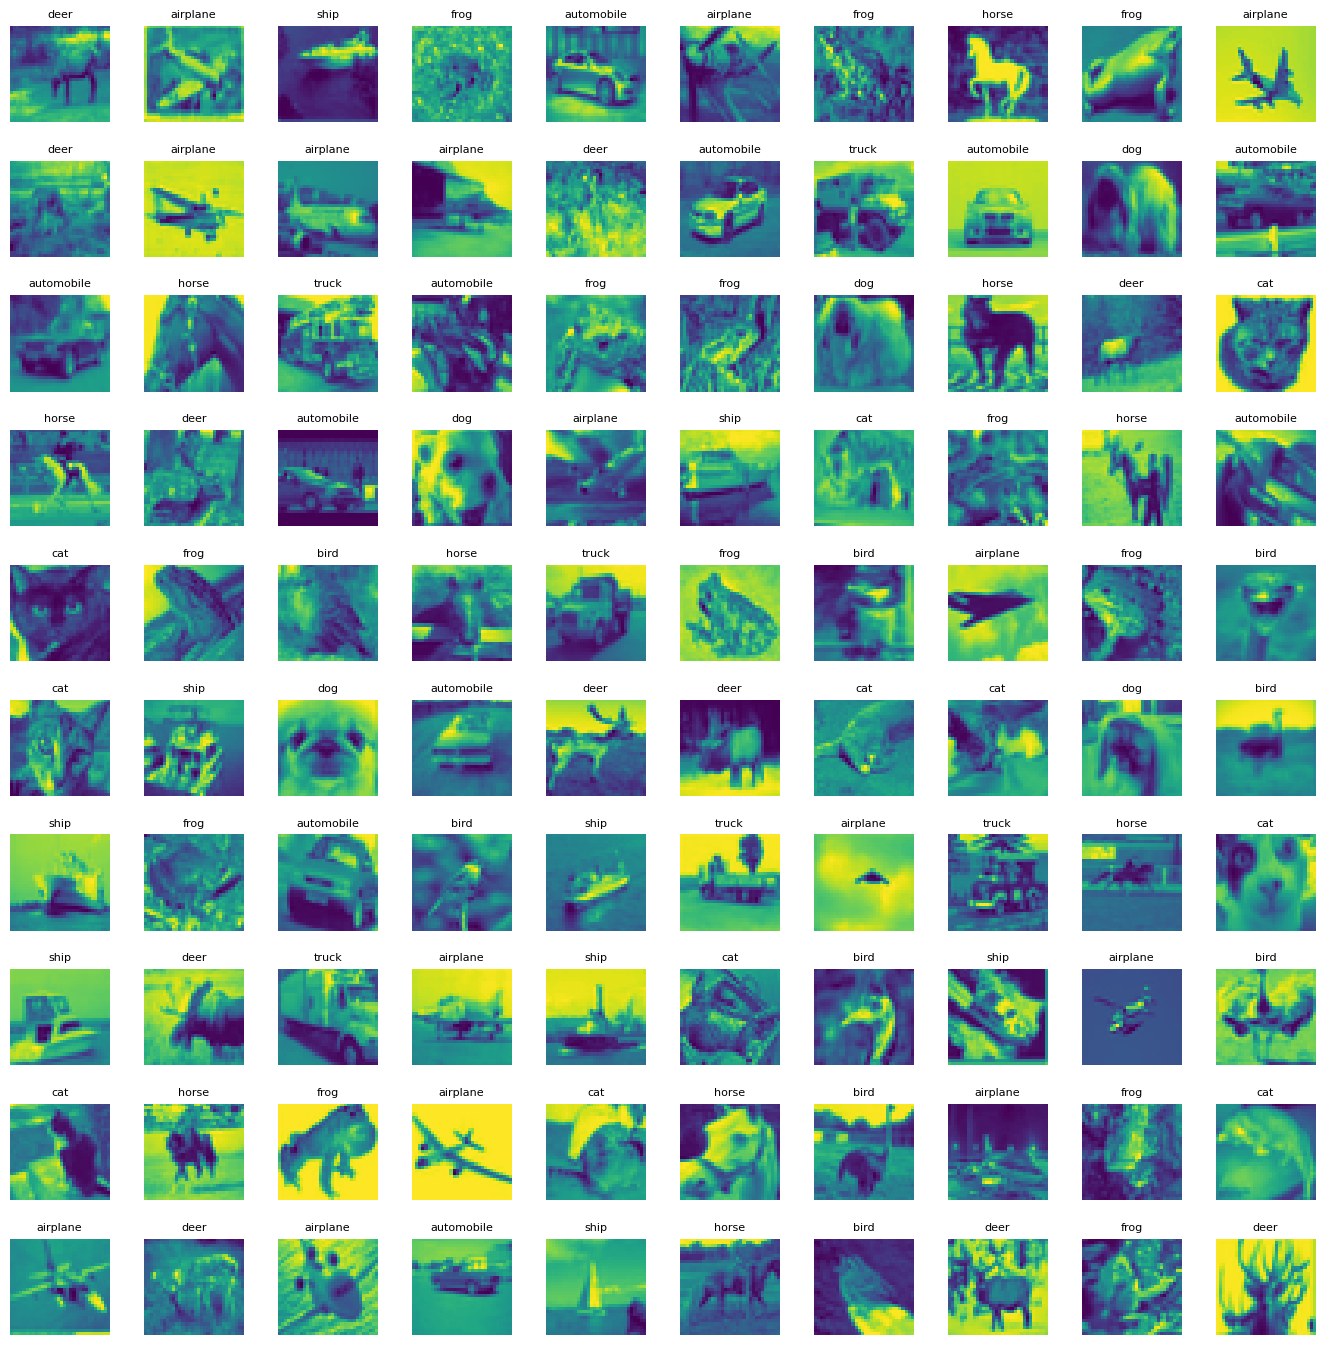

In [5]:
# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']

# Define the dimensions of the plot grid
W_grid = 10
L_grid = 10

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17)) #size of each image to be displayed

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_train = len(X_train) # get the length of the X_train dataset

for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables

    # Select a random number
    index = np.random.randint(0, n_train)
    # read and display an image with the selected index
    axes[i].imshow(x_train_gry[index,1:])
    label_index = int(y_train[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

In [6]:
# Reshape the images to add an extra dimension
x_train_gry =x_train_gry.reshape(*(list(x_train_gry.shape) + [1]))
x_train_gry.shape

(50000, 32, 32, 1)

In [7]:
# Split dataset

X_train, X_val, y_train, y_val = train_test_split(x_train_gry, y_train, test_size=0.40, random_state=42)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (30000, 32, 32, 1)
y_train shape: (30000, 1)
X_val shape: (20000, 32, 32, 1)
y_val shape: (20000, 1)


In [8]:
# Scale the data by normalizing pixel values
X_train = X_train / 255.0
X_val =X_val / 255.0
x_test_gry = x_test_gry / 255.0

# Transform target variable into one-hotencoding
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)
y_test = to_categorical(y_test, 10)

In [9]:
# compute time
class TimingCallback(tf.keras.callbacks.Callback):
 def __init__(self):
   self.logs=[]
 def on_epoch_begin(self, epochs, logs={}):
   self.starttime=time()
 def on_epoch_end(self, epochs, logs={}):
   self.logs.append(time()-self.starttime)

# record time
cbt = TimingCallback()

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical



# Define ResNet model
def resnet_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True):
    shortcut = x
    if conv_shortcut:
        shortcut = layers.Conv2D(filters, 1, strides=stride)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x

def resnet(input_shape, num_classes=10):
    input_tensor = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, 3, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    num_blocks_list = [2, 2, 2]  # Number of residual blocks in each stage
    for i, num_blocks in enumerate(num_blocks_list):
        stride = 2 if i > 0 else 1
        x = resnet_block(x, 64, stride=stride)
        for _ in range(num_blocks - 1):
            x = resnet_block(x, 64)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=input_tensor, outputs=x)
    return model

# Create ResNet model
input_shape = X_train.shape[1:]
model = resnet(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model
history10 = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[cbt])

# Evaluate the model
# test_loss, test_acc = model.evaluate(x_test_gry, y_test, verbose=2)
# print(f"\nTest accuracy: {test_acc*100:.2f}%")


Epoch 1/20
938/938 [==============================] - 1292s 1s/step - loss: 1.3836 - accuracy: 0.5055 - val_loss: 1.6497 - val_accuracy: 0.4602
Epoch 2/20
938/938 [==============================] - 1280s 1s/step - loss: 0.9846 - accuracy: 0.6556 - val_loss: 1.5527 - val_accuracy: 0.5055
Epoch 3/20
938/938 [==============================] - 1291s 1s/step - loss: 0.8017 - accuracy: 0.7219 - val_loss: 0.9040 - val_accuracy: 0.6834
Epoch 4/20
938/938 [==============================] - 1291s 1s/step - loss: 0.6786 - accuracy: 0.7650 - val_loss: 0.8701 - val_accuracy: 0.7042
Epoch 5/20
938/938 [==============================] - 1297s 1s/step - loss: 0.5842 - accuracy: 0.7987 - val_loss: 0.8692 - val_accuracy: 0.7164
Epoch 6/20
938/938 [==============================] - 1288s 1s/step - loss: 0.4925 - accuracy: 0.8321 - val_loss: 0.8120 - val_accuracy: 0.7319
Epoch 7/20
938/938 [==============================] - 1273s 1s/step - loss: 0.4221 - accuracy: 0.8547 - val_loss: 0.7520 - val_accuracy:

InvalidArgumentError: Graph execution error:

Detected at node model/conv2d/BiasAdd defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 250, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 748, in __init__

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-10-3b66702eaca6>", line 59, in <cell line: 59>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2296, in evaluate

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 4108, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2066, in test_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2049, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2037, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1917, in test_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 311, in call

convolution input must be 4-dimensional: [32,32,32]
	 [[{{node model/conv2d/BiasAdd}}]] [Op:__inference_test_function_136529]

In [12]:
# Reshape the images to add an extra dimension
x_test_gry =x_test_gry.reshape(*(list(x_test_gry.shape) + [1]))
x_test_gry.shape

(10000, 32, 32, 1)

In [13]:
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test_gry, y_test, verbose=2)
print(f"\nTest accuracy: {test_acc*100:.2f}%")

313/313 - 85s - loss: 1.3599 - accuracy: 0.7074 - 85s/epoch - 271ms/step

Test accuracy: 70.74%


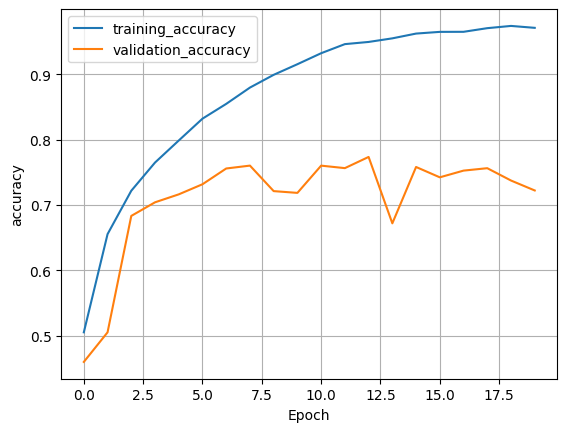

In [14]:
# Plot accuracy chart

def plot_history(history):

   plt.plot(history.history['accuracy'], label='training_accuracy')
   plt.plot(history.history['val_accuracy'], label='validation_accuracy')

   plt.xlabel('Epoch')
   plt.ylabel('accuracy')
   plt.grid(True)

   plt.legend()
   plt.show()


plot_history(history10)

In [15]:
# training & validation accuracy data table for resnet

epoch_time = pd.Series(cbt.logs)
table=pd.DataFrame(history10.history)
table['epoch_time'] = epoch_time.values

In [16]:
table[['accuracy', 'val_accuracy', 'epoch_time']] # accuracy = training accuracy

,accuracy,val_accuracy,epoch_time
0,0.505467,0.46020,1291.839468
1,0.655567,0.50545,1279.930571
2,0.721933,0.68345,1290.862641
3,0.765033,0.70425,1290.549159
4,0.798733,0.71640,1297.181839
5,0.832133,0.73185,1287.983054
6,0.854733,0.75595,1272.788867
7,0.879667,0.76035,1281.460068
8,0.899167,0.72135,1318.539222
9,0.915400,0.71865,1279.263879


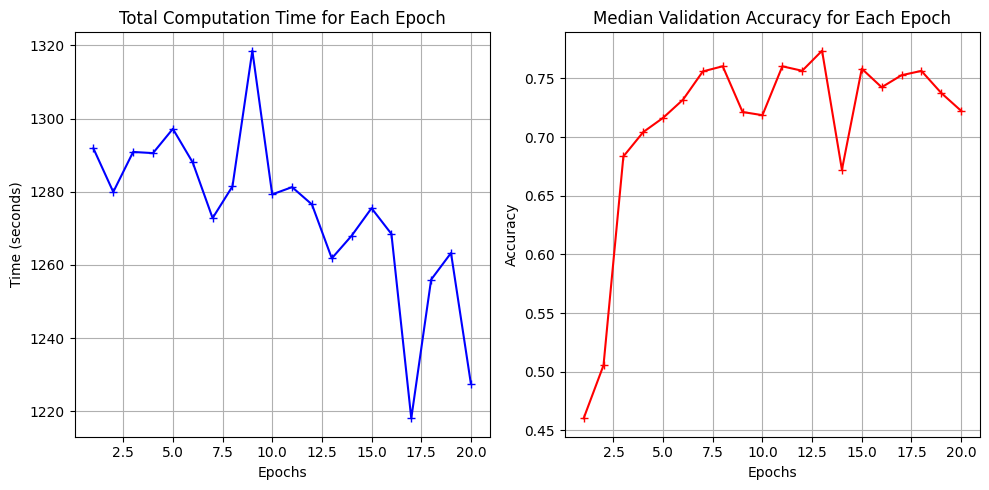

In [17]:
# chart or median processing time per epoch and median validation accuracy per epoch

epochs = np.arange(1, 21) # 20 epochs


# Plotting total computation time
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, table.epoch_time, marker='+', linestyle='-', color='b')
plt.title('Total Computation Time for Each Epoch')
plt.xlabel('Epochs')
plt.ylabel('Time (seconds)')
plt.grid(True)


# Plotting median validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, table.val_accuracy, marker='+', linestyle='-', color='r')
plt.title('Median Validation Accuracy for Each Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)


plt.tight_layout()
plt.show()

In [18]:
median_processing_time = np.median(table.epoch_time)
print(f"Median Processing Time per Epochs: {median_processing_time:.2f} seconds")

Median Processing Time per Epochs: 1277.89 seconds


In [19]:
median_validation_accuracy = np.median(table.val_accuracy)
print(f"Median Validation Accuracy per Epochs: {median_validation_accuracy*100:.2f} %")

Median Validation Accuracy per Epochs: 73.47 %
